# Assayable biological processes
> Biological processes mapped to assays

- toc: true 
- badges: true
- comments: true
- categories: [useful_resources]
- image: images/chart-preview.png

Whilst it often useful to use [GeneOntology](http://geneontology.org/)'s biological processes to approximate the pathomechanisms of a disease, one frequently finds themself whittling through a list of enriched biological processes, trying to find a process that is actually assayable.

Fortunately, living deep within the Supplementary Material of a Nature [paper](https://www.nature.com/articles/ng.3259#MOESM9), lives a curated list of  processes **testable through specific molecular experiments**.

In [1]:
#collapse-hide
!pip install gseapy
import gseapy as gp
import pandas as pd

     |████████████████████████████████| 525 kB 8.8 MB/s 
     |████████████████████████████████| 199 kB 13.6 MB/s 
     |████████████████████████████████| 44 kB 2.1 MB/s 
     |████████████████████████████████| 47 kB 3.7 MB/s 
     |████████████████████████████████| 255 kB 42.2 MB/s 
     |████████████████████████████████| 5.8 MB 15.8 MB/s 
     |████████████████████████████████| 251 kB 66.8 MB/s 
     |████████████████████████████████| 127 kB 52.7 MB/s 
  Created wheel for bioservices: filename=bioservices-1.8.1-py3-none-any.whl size=229863 sha256=a6ca9cf361dd357d4ea33fbee0da273f7f405c9056a19e18ee51defc9872a7a3
  Stored in directory: /root/.cache/pip/wheels/f7/54/e9/a7bf159efa0c5883ffaa9934525d90bf602d8f20290c2e4a33
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=ac9ebb8890661238c832c612ec742ac5b1b18edcf86b244008bcec33eae6ae68
  Stored in directory: /root/.cache/pip/wheels/82/ab/83/fdfc4017ea44a585b6754752cc5f63f2d0d63fcc1317e7174b
  Created whe

In [2]:
#collapse-hide
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fng.3259/MediaObjects/41588_2015_BFng3259_MOESM9_ESM.xlsx
!mv 41588_2015_BFng3259_MOESM9_ESM.xlsx processes.xlsx
!wget https://static-content.springer.com/esm/art%3A10.1038%2Fng.3259/MediaObjects/41588_2015_BFng3259_MOESM12_ESM.xlsx
!mv 41588_2015_BFng3259_MOESM12_ESM.xlsx tissue_go_mapping.xlsx
!wget https://raw.githubusercontent.com/finlayiainmaclean/datadump/main/EFO_0000342-associated-diseases.csv
!curl -OL https://github.com/finlayiainmaclean/datadump/blob/main/genego.tab.zip?raw=true
!unzip genego.tab.zip?raw=true

processes = pd.read_excel('processes.xlsx', skiprows=1)

--2021-10-07 08:35:26--  https://static-content.springer.com/esm/art%3A10.1038%2Fng.3259/MediaObjects/41588_2015_BFng3259_MOESM9_ESM.xlsx
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.springer.com)|151.101.0.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37992 (37K) [application/octet-stream]
Saving to: ‘41588_2015_BFng3259_MOESM9_ESM.xlsx’

41588_2015_BFng3259 100%[===================>]  37.10K  --.-KB/s    in 0.001s  

2021-10-07 08:35:26 (34.9 MB/s) - ‘41588_2015_BFng3259_MOESM9_ESM.xlsx’ saved [37992/37992]

--2021-10-07 08:35:26--  https://static-content.springer.com/esm/art%3A10.1038%2Fng.3259/MediaObjects/41588_2015_BFng3259_MOESM12_ESM.xlsx
Resolving static-content.springer.com (static-content.springer.com)... 151.101.0.95, 151.101.64.95, 151.101.128.95, ...
Connecting to static-content.springer.com (static-content.spr

In [4]:
#hide_input
processes

,GO Term Name,GO Term ID
0,abscisic_acid_mediated_signaling_pathway,GO:0009738
1,abscisic_acid_metabolic_process,GO:0009687
2,acetyl_coa_biosynthetic_process_from_acetate,GO:0019427
3,acetylcholine_transport,GO:0015870
4,actin_cytoskeleton_reorganization,GO:0031532
...,...,...
968,xanthophyll_metabolic_process,GO:0016122
969,xenobiotic_metabolic_process,GO:0006805
970,xylan_catabolic_process,GO:0045493
971,xylem_and_phloem_pattern_formation,GO:0010051


The paper also mapped tissues to biological processes via first using co-occurences, and then manually curating the list.

In [5]:
#collapse-hide
tissue_mapping = pd.read_excel('tissue_go_mapping.xlsx', skiprows=1).set_index('BRENDA Tissue ID')
bto2name = dict(zip(tissue_mapping.index, tissue_mapping.Tissue))

go2bto = {}
for bto, row in tissue_mapping.drop(columns=['Tissue']).iterrows():
  for go in row:
    if go is None:
      break
    go2bto[go] = bto

Let's run a prerank gene set enrichment analysis, using only testable biological processes. First we need to generate a geneset.

In [6]:
#collapse-hide
import numpy as np
genego = pd.read_csv('genego.tab',sep='\t')
gene2go = []
go2name = {}
for row in genego.dropna(subset=['Gene ontology (biological process)']).itertuples():
  for _go in row[4].split('; '):
    go = _go.split('[')[1].replace(']','')
    name = _go.split(' [')[0]
    gene2go.append((row[2], f"{name} ({go})"))
    go2name[go] = name

gene2go = pd.DataFrame(gene2go,columns =['gene','go'])
gene2go = gene2go.groupby('go')['gene'].apply(list).to_dict()

Let's run the prerankGSEA for chronic pancreatitis genes, defined by the overall association score in OpenTargets.

In [7]:
#collapse-show
cp_targets = pd.read_csv('EFO_0000342-associated-diseases.csv')
cp_targets.head(10)

,symbol,overallAssociationScore,geneticAssociations,somaticMutations,drugs,pathwaysSystemsBiology,textMining,rnaExpression,animalModels,targetName
0,PRSS1,0.834384,0.9183390021590296,No data,No data,No data,0.1838682865290527,No data,0.5693580106773287,serine protease 1
1,SPINK1,0.804783,0.8862311248507138,No data,No data,No data,0.23856390277427408,No data,0.3298784490540059,serine peptidase inhibitor Kazal type 1
2,CTRC,0.740035,0.8910696416923192,No data,No data,No data,0.09941106709313025,No data,0.29290105828927904,chymotrypsin C
3,CFTR,0.696968,0.9074161629304885,No data,No data,No data,0.2678564156117781,No data,0.3978335055391351,CF transmembrane conductance regulator
4,VDR,0.369580,No data,No data,0.607930797611621,No data,No data,No data,No data,vitamin D receptor
5,UTRN,0.327407,0.5385593475017613,No data,No data,No data,No data,No data,No data,utrophin
6,SCN4A,0.327078,No data,No data,0.5380187558862847,No data,No data,No data,No data,sodium voltage-gated channel alpha subunit 4
7,NR3C1,0.323382,No data,No data,0.5319394479101685,No data,No data,No data,No data,nuclear receptor subfamily 3 group C member 1
8,CDKN2A,0.295810,No data,0.4559480982087158,No data,No data,0.6127525799017898,No data,No data,cyclin dependent kinase inhibitor 2A
9,KRAS,0.278109,No data,0.4559480982087158,No data,No data,0.030396539880581056,No data,No data,"KRAS proto-oncogene, GTPase"


Running the enrichment, we see proteolysis and RNA polymerase II transcription are the most enriched processes.

In [10]:
#Run gsea
pre_res = gp.prerank(rnk=cp_targets[['symbol','overallAssociationScore']], gene_sets=gene2go,
                     processes=2,
                     permutation_num=500, # reduce number to speed up testing
                     outdir='prerank_report', format='png', seed=6)
pre_res = pd.read_csv('prerank_report/gseapy.prerank.gene_sets.report.csv')
pre_res.head(10)
#Get GO name
# pre_res['go_name'] = pre_res.Term.apply(go2name.get)
# #Map tissue
# pre_res['bto'] = pre_res.Term.apply(go2bto.get)
# pre_res['tissue_name'] = pre_res.bto.apply(bto2name.get)

,Term,es,nes,pval,fdr,geneset_size,matched_size,genes,ledge_genes
0,transcription initiation from RNA polymerase I...,0.827233,1.444565,0.014085,0.509843,140,17,VDR;NR3C1;CREBBP;CCN2;PGR;THRA;PPARG;E2F2;NR4A...,VDR;NR3C1;CREBBP;CCN2;PGR;THRA
1,proteolysis (GO:0006508),0.836005,1.472423,0.000000,0.584968,253,31,PRSS1;CTRC;PCSK2;CPA1;CTSS;CTRB2;CTRB1;CTSB;EL...,PRSS1;CTRC;PCSK2;CPA1;CTSS;CTRB2;CTRB1;CTSB
2,lung development (GO:0030324),0.303998,0.524236,1.000000,0.997848,80,15,CCN2;WNT5A;PDPN;VEGFA;NOTCH1;PDGFRA;EGFR;EP300...,CCN2;WNT5A;PDPN;VEGFA;NOTCH1
3,anatomical structure morphogenesis (GO:0009653),0.798351,1.376056,0.030120,1.000000,131,18,SMAD4;ONECUT1;PKD1;SMAD3;SRY;TH;KRT18;SMAD2;MC...,SMAD4;ONECUT1;PKD1
4,activation of cysteine-type endopeptidase acti...,0.742733,1.308484,0.034068,1.000000,89,21,CDKN2A;NGFR;S100A9;NGF;EIF2AK3;NLRP1;BAD;PPARG...,CDKN2A;NGFR;S100A9;NGF;EIF2AK3;NLRP1;BAD
5,protein deubiquitination (GO:0016579),0.736472,1.301402,0.038000,1.000000,265,25,CFTR;SMAD4;IL33;PTEN;TP53;BAP1;CYLD;HIF1A;MYC;...,CFTR;SMAD4
6,extracellular matrix disassembly (GO:0022617),0.760249,1.310297,0.040161,1.000000,65,17,PRSS1;CTSS;CTRB2;CTRB1;ELANE;CTSL;CTSV;CD44;LA...,PRSS1;CTSS;CTRB2;CTRB1
7,glucose homeostasis (GO:0042593),0.695962,1.232535,0.056000,1.000000,104,37,NGFR;PDX1;BHLHA15;GCK;INS;LEP;GCGR;WFS1;LEPR;C...,NGFR;PDX1;BHLHA15;GCK;INS;LEP;GCGR;WFS1;LEPR;C...
8,positive regulation of pri-miRNA transcription...,0.721529,1.255786,0.084000,1.000000,41,21,NR3C1;SMAD4;NGFR;TGFB1;TP53;PPARG;HIF1A;TNF;JU...,NR3C1;SMAD4;NGFR
9,endocrine pancreas development (GO:0031018),0.738487,1.282722,0.088000,1.000000,22,15,HNF1B;ONECUT1;EIF2AK3;PAX4;MNX1;GIPR;INSM1;NEU...,HNF1B;ONECUT1;EIF2AK3;PAX4;MNX1;GIPR;INSM1;NEU...


In [16]:
# from IPython.display import Image
# Image('proteolysis (GO_0006508).prerank.png',width=1000, height=1000)

Let's take a look at the ES plot for proteolysis.

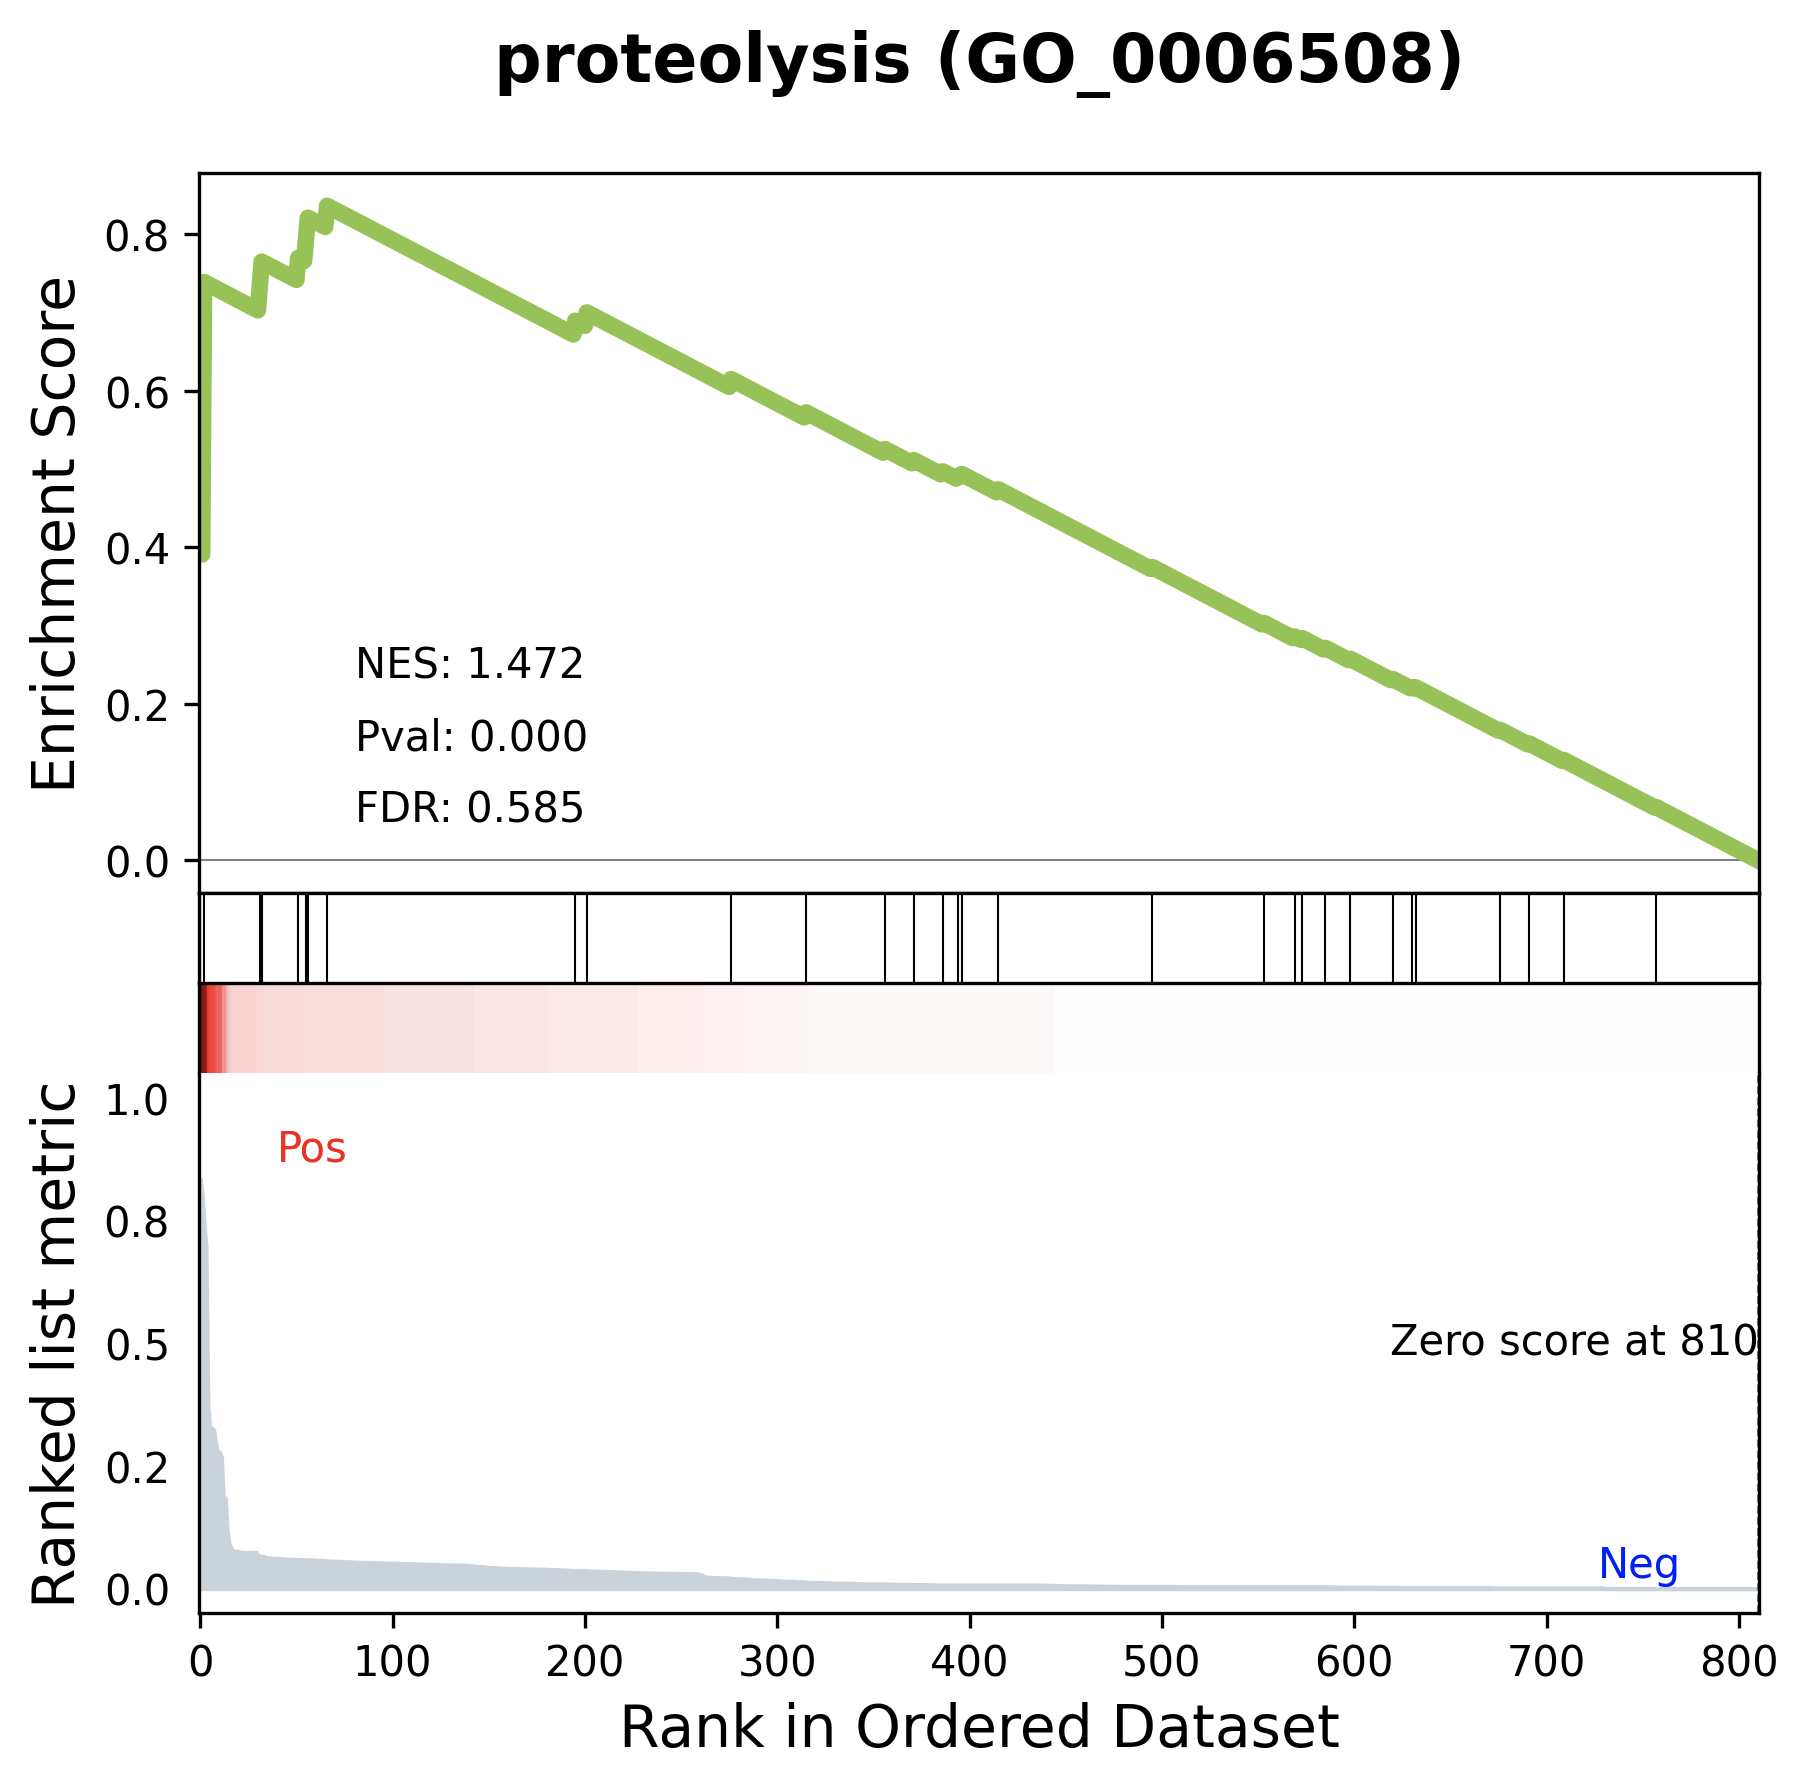